In [1]:
import pandas as pd
import numpy as np

from dateutil.parser import parse
from datetime import datetime
import dateutil.parser


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import glob
import os
import zipfile

In [2]:
# read in an example CSV 
df = pd.read_csv("combined_csv.txt")

In [3]:
# preview the data 
df.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
2562218,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/21/2017,05:00:00,REGULAR,5554,297
2562219,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/21/2017,09:00:00,REGULAR,5554,297
2562220,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/21/2017,13:00:00,REGULAR,5554,297
2562221,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/21/2017,17:00:00,REGULAR,5554,297
2562222,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/21/2017,21:00:00,REGULAR,5554,297


In [4]:
df.rename(columns = {
    'C/A': 'area',
    'UNIT': 'unit',
    'SCP': 'scp',
    'STATION': 'station',
    'LINENAME': 'linename',
    'DIVISION': 'division',
    'DATE': 'date',
    'TIME': 'time',
    'DESC': 'desc',
    'ENTRIES': 'entries',
    'EXITS                                                               ': 'exits'},
    inplace = True)

In [5]:
df.head()

,area,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/08/2017,00:00:00,REGULAR,6127245,2076158
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/08/2017,04:00:00,REGULAR,6127285,2076165
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/08/2017,08:00:00,REGULAR,6127304,2076196
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/08/2017,12:00:00,REGULAR,6127409,2076284
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/08/2017,16:00:00,REGULAR,6127654,2076350


## Entries

In [6]:
# group the dataframe by turnstile identifiers and date columns and aggregate the entry column by taking minumums. 
# Since the entry column tracks cumulative entries, for any given day the total entries should be given by the difference 
# between the min of next day's entry values and the min of this day's entry values.

entries_byDate = df.groupby(['area','unit','scp','station','date']).entries.agg({'min_entries':'min'})
entries_byDate = entries_byDate.reset_index()

entries_byDate['daily_entries'] = entries_byDate.groupby(['area','unit','scp','station']).min_entries.diff().shift(-1)


/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


In [7]:
# set the negative entry values or excessively large entry values to NaN 
# (these are invalid and something went wrong with the cumulative count).

entries_byDate.loc[entries_byDate['daily_entries'] <= 0, 'daily_entries'] = np.nan
entries_byDate.loc[entries_byDate['daily_entries'] > 100000, 'daily_entries'] = np.nan
entries_byDate.head()

,area,unit,scp,station,date,min_entries,daily_entries
0,A002,R051,02-00-00,59 ST,02/25/2017,6064627,832.0
1,A002,R051,02-00-00,59 ST,02/26/2017,6065459,631.0
2,A002,R051,02-00-00,59 ST,02/27/2017,6066090,1576.0
3,A002,R051,02-00-00,59 ST,02/28/2017,6067666,1432.0
4,A002,R051,02-00-00,59 ST,03/01/2017,6069098,1541.0


In [8]:
# combine turnstyles in the same area/unit/station

df_TurnCombo = entries_byDate.reset_index().drop('scp',axis=1)
df_TurnCombo = entries_byDate.groupby(['area','unit','station','date'])['daily_entries'].sum()
df_TurnCombo.head()

area  unit  station  date      
A002  R051  59 ST    02/25/2017     8319.0
                     02/26/2017     6371.0
                     02/27/2017    13991.0
                     02/28/2017    14188.0
                     03/01/2017    14562.0
Name: daily_entries, dtype: float64

In [9]:
# combine turnstyles in the same station

df_StatCombo = df_TurnCombo.reset_index().drop(['area','unit'],axis=1)
df_StatCombo = df_StatCombo.groupby(['station','date'])['daily_entries'].sum()

df_StatCombo.head(7)

station  date      
1 AV     02/25/2017    17508.0
         02/26/2017    13025.0
         02/27/2017    21650.0
         02/28/2017    22466.0
         03/01/2017    22943.0
         03/02/2017    23665.0
         03/03/2017    25210.0
Name: daily_entries, dtype: float64

In [10]:
df_StatCombo = df_StatCombo.reset_index()
df_Stat59 = df_StatCombo[df_StatCombo['station'] == '59 ST']

dates = [dateutil.parser.parse(date) for date in df_Stat59['date'].values]
counts = df_Stat59['daily_entries'].values

In [11]:
# sum total station entries over the time period

df_StatTotal = df_StatCombo.groupby('station')['daily_entries'].sum()
df_StatTotal.sort_values(ascending=False,inplace=True)
df_StatTotal.head(10)

station
34 ST-PENN STA     13066865.0
GRD CNTRL-42 ST    11268314.0
34 ST-HERALD SQ     9336376.0
23 ST               9287101.0
14 ST-UNION SQ      8634302.0
TIMES SQ-42 ST      7870813.0
42 ST-PORT AUTH     7410113.0
FULTON ST           7095901.0
86 ST               7033492.0
125 ST              5962926.0
Name: daily_entries, dtype: float64

## EXITS 

Same process as the entries

In [12]:
exits_byDate = df.groupby(['area','unit','scp','station','date']).exits.agg({'min_exits':'min'})
exits_byDate = exits_byDate.reset_index()

exits_byDate['daily_exits'] = exits_byDate.groupby(['area','unit','scp','station']).min_exits.diff().shift(-1)

/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [13]:
exits_byDate.loc[exits_byDate['daily_exits'] <= 0, 'daily_exits'] = np.nan
exits_byDate.loc[exits_byDate['daily_exits'] > 100000, 'daily_exits'] = np.nan
exits_byDate.head()

,area,unit,scp,station,date,min_exits,daily_exits
0,A002,R051,02-00-00,59 ST,02/25/2017,2055986,307.0
1,A002,R051,02-00-00,59 ST,02/26/2017,2056293,213.0
2,A002,R051,02-00-00,59 ST,02/27/2017,2056506,482.0
3,A002,R051,02-00-00,59 ST,02/28/2017,2056988,732.0
4,A002,R051,02-00-00,59 ST,03/01/2017,2057720,621.0


In [14]:
df_TurnCombo2 = exits_byDate.reset_index().drop('scp',axis=1)
df_TurnCombo2 = exits_byDate.groupby(['area','unit','station','date'])['daily_exits'].sum()
df_TurnCombo2.head()

area  unit  station  date      
A002  R051  59 ST    02/25/2017    5037.0
                     02/26/2017    3718.0
                     02/27/2017    7971.0
                     02/28/2017    9109.0
                     03/01/2017    9402.0
Name: daily_exits, dtype: float64

In [15]:
df_StatCombo2 = df_TurnCombo2.reset_index().drop(['area','unit'],axis=1)
df_StatCombo2 = df_StatCombo2.groupby(['station','date'])['daily_exits'].sum()

df_StatCombo2.head(7)

station  date      
1 AV     02/25/2017    19515.0
         02/26/2017    14453.0
         02/27/2017    22487.0
         02/28/2017    23183.0
         03/01/2017    23424.0
         03/02/2017    24872.0
         03/03/2017    26646.0
Name: daily_exits, dtype: float64

In [16]:
df_StatCombo2 = df_StatCombo2.reset_index()
df_Stat592 = df_StatCombo2[df_StatCombo2['station'] == '59 ST']

dates2 = [dateutil.parser.parse(date) for date in df_Stat592['date'].values]
counts2 = df_Stat592['daily_exits'].values

In [17]:
df_StatTotal2 = df_StatCombo2.groupby('station')['daily_exits'].sum()
df_StatTotal2.sort_values(ascending=False,inplace=True)
df_StatTotal2.head(10)

station
34 ST-PENN STA     11074637.0
GRD CNTRL-42 ST    10013543.0
34 ST-HERALD SQ     8807150.0
TIMES SQ-42 ST      7317382.0
14 ST-UNION SQ      7296228.0
23 ST               6817729.0
42 ST-PORT AUTH     6013113.0
86 ST               5777097.0
FULTON ST           5751854.0
125 ST              4922616.0
Name: daily_exits, dtype: float64

## Overall Traffic

In [18]:
# add the two dataframes together

df_combined = df_StatTotal.add(df_StatTotal2, fill_value=0)
df_combined.sort_values(ascending=False,inplace=True)
df_combined.head(10)

station
34 ST-PENN STA     24141502.0
GRD CNTRL-42 ST    21281857.0
34 ST-HERALD SQ    18143526.0
23 ST              16104830.0
14 ST-UNION SQ     15930530.0
TIMES SQ-42 ST     15188195.0
42 ST-PORT AUTH    13423226.0
FULTON ST          12847755.0
86 ST              12810589.0
125 ST             10885542.0
dtype: float64

TypeError: object of type 'int' has no len()

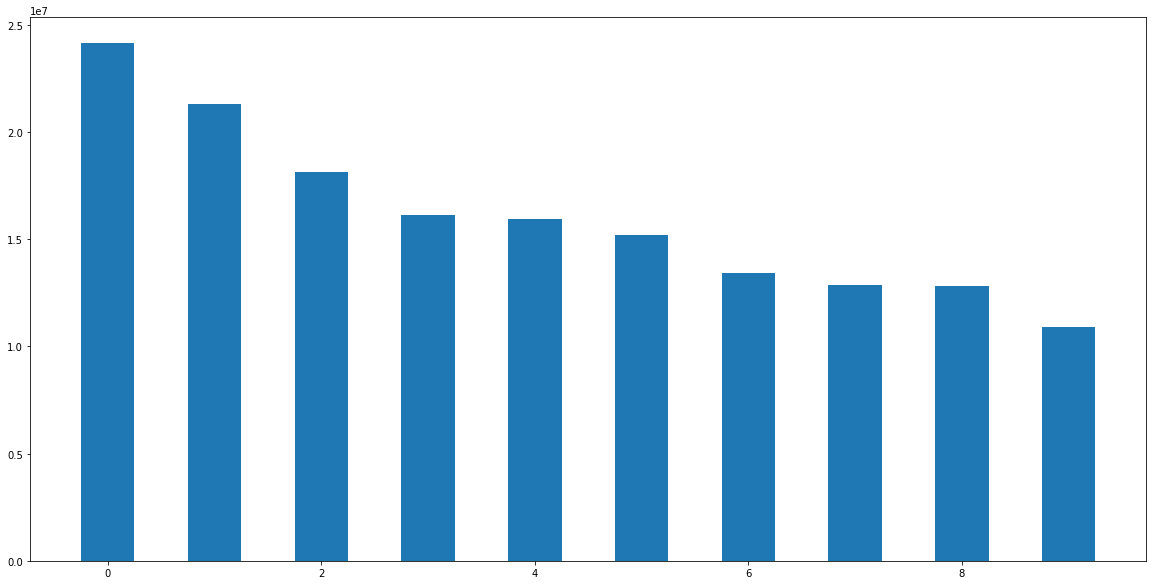

In [72]:
s = pd.Series({'34 ST-PENN STA': 24141502, 'GRD CNTRL-42 ST': 21281857, '34 ST-HERALD SQ': 18143526,
              '23 ST': 16104830,'14 ST-UNION SQ': 15930530, 'TIMES SQ-42 ST': 15188195, '42 ST-PORT AUTH': 13423226,
              'FULTON ST': 12847755, '86 ST': 12810589, '125 ST': 10885542   },
               name='article_id')

s.plot(kind="bar", figsize=(20,10), title='Top Station Traffic', yticks=500000)




## Graphs + Traffic By Day of the Week

In [20]:
# plot time series for entries across all stations during the collection period 

dates = [dateutil.parser.parse(date) for date in df_StatCombo['date'].values]
counts = df_StatCombo['daily_entries'].values

Text(0, 0.5, 'Total Entries')

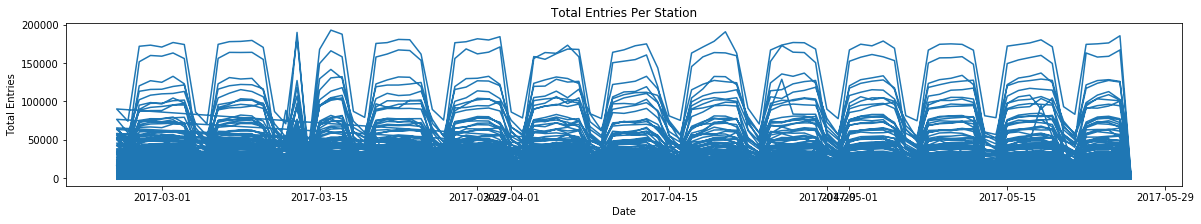

In [22]:
plt.figure(figsize=(20,3))
plt.plot(dates,counts)
plt.title('Total Entries Per Station')
plt.xlabel('Date')
plt.ylabel('Total Entries')

In [38]:
# plot time series for exits across all stations during the collection period 

dates = [dateutil.parser.parse(date) for date in df_StatCombo2['date'].values]
counts = df_StatCombo2['daily_exits'].values

Text(0, 0.5, 'Total Exits')

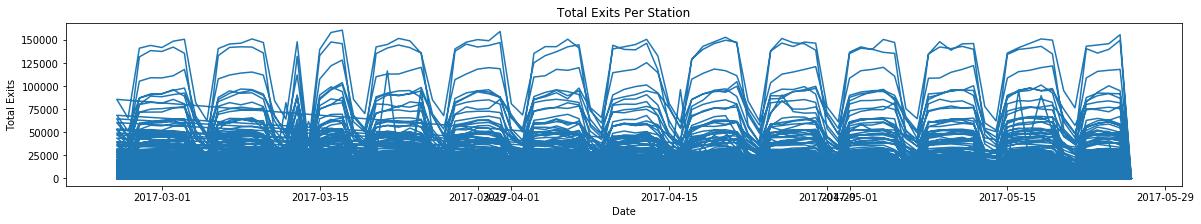

In [25]:
plt.figure(figsize=(20,3))
plt.plot(dates,counts)
plt.title('Total Exits Per Station')
plt.xlabel('Date')
plt.ylabel('Total Exits')

In [41]:
df_StatCombo = df_StatCombo.reset_index()
df_Top_Stations = df_StatCombo[df_StatCombo['station': '59 ST',
                               '34 ST-PENN STA',
                               'GRD CNTRL-42 ST',
                               '34 ST-HERALD SQ',
                               '23 ST',
                               '14 ST-UNION SQ',
                               'TIMES SQ-42 ST',
                               '42 ST-PORT AUTH',
                               'FULTON ST',
                               '86 ST',
                               '125 ST']
                                  

dates = [dateutil.parser.parse(date) for date in df_Top_Stations['date'].values]
counts = df_StatCombo2['daily_entries'].values

SyntaxError: invalid syntax (<ipython-input-41-0b0c0e9f3176>, line 15)